<a href="https://colab.research.google.com/github/rockingboi/MLM-48-GLA/blob/main/MLM_48.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import zipfile
import os

zip_path = "/content/energy+efficiency.zip"
extract_dir = "/content/data/energy_efficiency_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)
extracted_files


['ENB2012_data.xlsx']

In [39]:
import pandas as pd

file_path = os.path.join(extract_dir, 'ENB2012_data.xlsx')
df = pd.read_excel(file_path)

df.head(), df.columns.tolist()


(     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
 0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
 1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
 2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
 3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
 4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28,
 ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2'])

In [40]:
from sklearn.preprocessing import MinMaxScaler

df.columns = [
    "Relative_Compactness", "Surface_Area", "Wall_Area", "Roof_Area",
    "Overall_Height", "Orientation", "Glazing_Area", "Glazing_Area_Distribution",
    "Heating_Load", "Cooling_Load"
]

missing_values = df.isnull().sum()

features = df.iloc[:, 0:8]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

y_heating = df["Heating_Load"]
y_cooling = df["Cooling_Load"]

df.head(), missing_values, X_scaled[:5]


(   Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  Overall_Height  \
 0                  0.98         514.5      294.0     110.25             7.0   
 1                  0.98         514.5      294.0     110.25             7.0   
 2                  0.98         514.5      294.0     110.25             7.0   
 3                  0.98         514.5      294.0     110.25             7.0   
 4                  0.90         563.5      318.5     122.50             7.0   
 
    Orientation  Glazing_Area  Glazing_Area_Distribution  Heating_Load  \
 0            2           0.0                          0         15.55   
 1            3           0.0                          0         15.55   
 2            4           0.0                          0         15.55   
 3            5           0.0                          0         15.55   
 4            2           0.0                          0         20.84   
 
    Cooling_Load  
 0         21.33  
 1         21.33  
 2         21.3

In [77]:
features = df.iloc[:, 0:8].copy()
labels = df[["Heating_Load", "Cooling_Load"]].copy()

In [41]:
df

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [42]:
import gym
from gym import spaces
import numpy as np


In [118]:
class HVACEnv(gym.Env):
    def __init__(self, data):
        super(HVACEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.max_steps = len(self.data)
        # 0 = HVAC Off, 1 = Low Fan, 2 = High Fan, 3 = Setpoint Temp
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)

In [119]:
    def __init__(self, data):
        super(HVACEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.max_steps = len(self.data)


In [120]:
class EnergyEnv:
    def __init__(self, features, labels):
        self.features = features.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.current_step = 0
        self.max_steps = len(features) - 1

    def reset(self):
        self.current_step = 0
        return self.features.iloc[self.current_step].values

    def step(self, action):
        current_state = self.features.iloc[self.current_step].values
        heating_load = self.labels.iloc[self.current_step]["Heating_Load"]
        cooling_load = self.labels.iloc[self.current_step]["Cooling_Load"]

        temp_low, temp_high = 21, 24
        if action == 0:
            temp_setpoint = 25
        elif action == 1:
            temp_setpoint = 21
        elif action == 2:
            temp_setpoint = 23
        else:
            temp_setpoint = 22

        # try to minimize energy while staying within comfort range
        comfort_penalty = -1 if (temp_setpoint < temp_low or temp_setpoint > temp_high) else 0
        energy_penalty = (heating_load + cooling_load) / 100

        reward = energy_penalty + comfort_penalty

        self.current_step += 1
        done = self.current_step >= self.max_steps

        next_state = self.features.iloc[self.current_step].values if not done else np.zeros(8)
        return next_state, reward, done, {}


In [121]:
import numpy as np
def discretize_state(state, bins):
    """Discretizes a continuous state into discrete bins"""
    state_disc = []
    for i in range(len(state)):
        state_disc.append(np.digitize(state[i], bins[i]))
    return tuple(state_disc)
bins = [np.linspace(0, 1, 10) for _ in range(8)]
q_table = {}

alpha = 0.1       # Learning rate
gamma = 0.9       # Discount factor
epsilon = 1.0     # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 1000   # Number of episodes to train


In [122]:
actions = [
    (0, 0),    # HVAC off
    (1, 21),   # Low fan, setpoint 21°C
    (2, 23),   # High fan, setpoint 23°C
    (1, 24),   # Low fan, setpoint 24°C
]

In [123]:
# ε-greedy action selection
def select_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1, 2, 3])
    else:
        state_action_values = q_table[state]
        return max(state_action_values, key=state_action_values.get)

def update_q_value(state, action, reward, next_state, alpha, gamma):
    max_next_q_value = max(q_table[next_state].values())
    q_table[state][action] += alpha * (reward + gamma * max_next_q_value - q_table[state][action])

def decay_epsilon(epsilon, epsilon_decay, epsilon_min):
    return max(epsilon * epsilon_decay, epsilon_min)

In [124]:
env = EnergyEnv(pd.DataFrame(X_scaled), df[["Heating_Load", "Cooling_Load"]])

In [125]:
state = env.reset()
print(len(state))

8


In [126]:
rewards = []
epsilons = []

for episode in range(episodes):
    state = env.reset()
    disc_state = discretize_state(state[:8], bins)

    if disc_state not in q_table:
        q_table[disc_state] = {a: 0.0 for a in range(len(actions))}

    total_reward = 0
    done = False

    while not done:
        action = select_action(disc_state, epsilon)
        next_state, reward, done, _ = env.step(action)
        disc_next_state = discretize_state(next_state[:8], bins)

        if disc_next_state not in q_table:
            q_table[disc_next_state] = {a: 0.0 for a in range(len(actions))}

        update_q_value(disc_state, action, reward, disc_next_state, alpha, gamma)

        disc_state = disc_next_state
        total_reward += reward

    rewards.append(total_reward)
    epsilons.append(epsilon)
    epsilon = decay_epsilon(epsilon, epsilon_decay, epsilon_min)

    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")


Episode 0, Total Reward: 167.83, Epsilon: 0.995
Episode 100, Total Reward: 244.83, Epsilon: 0.603
Episode 200, Total Reward: 293.83, Epsilon: 0.365
Episode 300, Total Reward: 320.83, Epsilon: 0.221
Episode 400, Total Reward: 336.83, Epsilon: 0.134
Episode 500, Total Reward: 349.83, Epsilon: 0.081
Episode 600, Total Reward: 352.83, Epsilon: 0.049
Episode 700, Total Reward: 354.83, Epsilon: 0.030
Episode 800, Total Reward: 354.83, Epsilon: 0.018
Episode 900, Total Reward: 358.83, Epsilon: 0.011


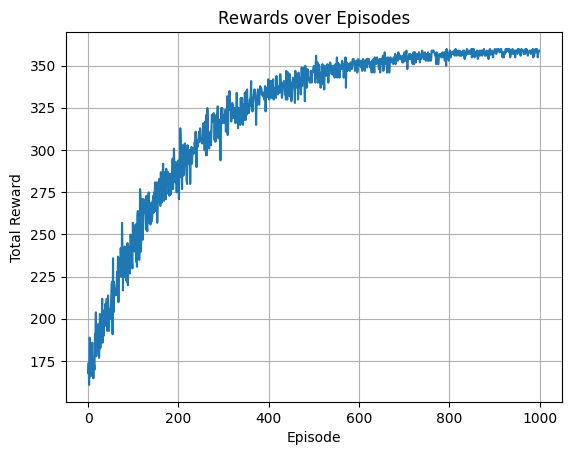

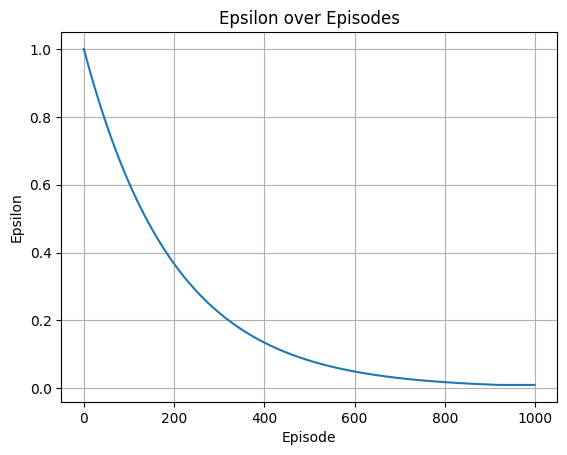

In [127]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.title("Rewards over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

plt.plot(epsilons)
plt.title("Epsilon over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.grid(True)
plt.show()
